In [11]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
import spacy
import sys
import graphviz

In [3]:
df = pd.read_csv('Data/winemag-data-130k-v2.csv')

In [76]:
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [4]:
'''
Columns definitions:
* Country: This column describes the country in which the wine was made, Initially this column isn't needed
* Description: This column describes the tastes given by the taster, this column is essential for the project because from this is where we are going to get the data for the sentiment analysis
* Designation: This column describes the vineyard within the winery where the grapes that made the wine are from, Initially this column isn't needed
* Points: This column describes the cata points given by the taster, this column is essential for the project
* Price: This column describes the price in euros for the wine bottle, this column isn't needed
* Province: This column describes the province or state that the wine is from, This column isn't needed
* Region 1: This column describes the wine growing area in a province or state (ie Napa), This column isn't needed
* Region 2: This column describes sometimes a second area, because sometimes there are more specific regions specified within a wine growing area, this column isn't needed
* taster_name: This column describes the tester name, This column isn't needed
'''

"\nColumns definitions:\n* Country: This column describes the country in which the wine was made, Initially this column isn't needed\n* Description: This column describes the tastes given by the taster, this column is essential for the project because from this is where we are going to get the data for the sentiment analysis\n* Designation: This column describes the vineyard within the winery where the grapes that made the wine are from, Initially this column isn't needed\n* Points: This column describes the cata points given by the taster, this column is essential for the project\n* Price: This column describes the price in euros for the wine bottle, this column isn't needed\n* Province: This column describes the province or state that the wine is from, This column isn't needed\n* Region 1: This column describes the wine growing area in a province or state (ie Napa), This column isn't needed\n* Region 2: This column describes sometimes a second area, because sometimes there are more s

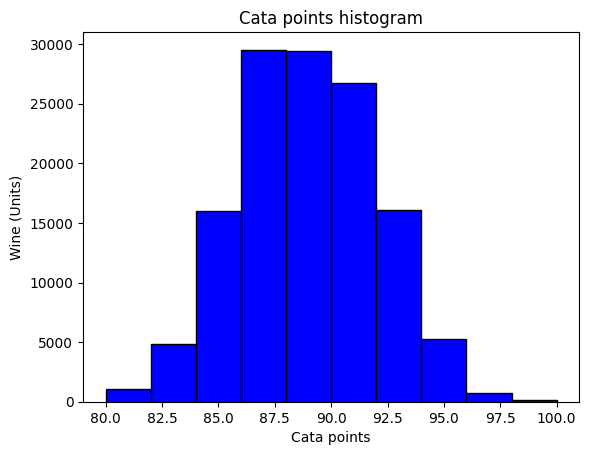

In [5]:
plt.hist(df['points'], color='blue', edgecolor='black')

plt.title('Cata points histogram')
plt.xlabel('Cata points')
plt.ylabel('Wine (Units)')
plt.show()

In [66]:
# This is a function that depending on its cuartile, it will categorize the points
def categorize_points(df):
    q1 = df['points'].quantile(0.25)
    q2 = df['points'].quantile(0.5)
    q3 = df['points'].quantile(0.75)
    bins = [0, q1, q2, q3, 101]
    labels = ['Mediocre', 'Promedio', 'Bueno', 'Excelente']
    df['points_category'] = pd.cut(df['points'], bins=bins, labels=labels)
    return df

df = categorize_points(df)
points = df.pop('points_category')
df.insert(4, 'points_category', points)
df.pop('points')

0         87
1         87
2         87
3         87
4         87
          ..
129966    90
129967    90
129968    90
129969    90
129970    90
Name: points, Length: 129971, dtype: int64

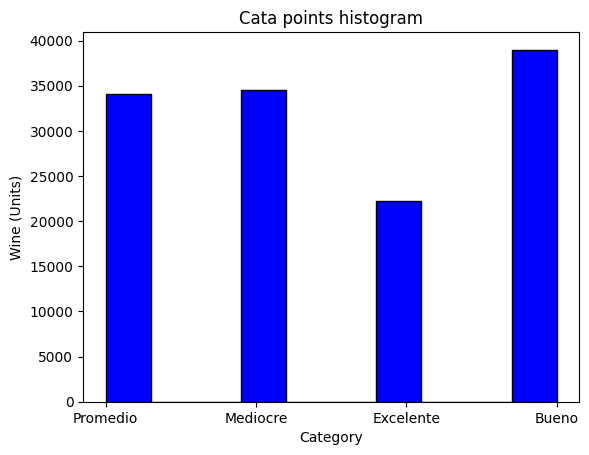

In [18]:
plt.hist(df['points_category'], color='blue', edgecolor='black')

plt.title('Cata points histogram')
plt.xlabel('Category')
plt.ylabel('Wine (Units)')
plt.show()

In [77]:
# This function counts the nulls in the dataframe

def count_nulls(df):
    nulls = df.isnull().sum()
    total = df.isnull().count()
    percentage = (nulls/total)*100
    print(percentage)
    
count_nulls(df)

Unnamed: 0                0.000000
country                   0.048472
description               0.000000
designation              28.825661
points                    0.000000
price                     6.921544
province                  0.048472
region_1                 16.347493
region_2                 61.136715
taster_name              20.192197
taster_twitter_handle    24.015357
title                     0.000000
variety                   0.000769
winery                    0.000000
dtype: float64


In [4]:
# This function inputs the country with the mode of the column

def input_country(df):
    df['country'] = df['country'].fillna(df['country'].mode()[0])
    return df

df = input_country(df)

# inputter

In [5]:
# This function inputs the designation with the mode of the column

def input_designation(df):
    df['designation'] = df['designation'].fillna(df['designation'].mode()[0])
    return df

df = input_designation(df)

In [ ]:
# This fuction deletes random rows from the dataframe to leave just 5000 rows

def delete_rows(df):
    df = df.sample(n=5000, random_state=1)
    return df

df = delete_rows(df)

In [11]:
# This function makes TF-IDF over the description column

def tf_idf(df):
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df['description'])
    return tfidf_matrix

tfidf_matrix = tf_idf(df)
print(tfidf_matrix)



  (0, 805)	0.09121722832515945
  (0, 4028)	0.19992763076668185
  (0, 1321)	0.16327093330928438
  (0, 23597)	0.20715792950330983
  (0, 5802)	0.13450847974617636
  (0, 1757)	0.13095419227027355
  (0, 29117)	0.44445250940531456
  (0, 18923)	0.19302934082522327
  (0, 10107)	0.24737949698948203
  (0, 19396)	0.25367775335393417
  (0, 14353)	0.2470680390582283
  (0, 19599)	0.08732259047918987
  (0, 13191)	0.15611349687048337
  (0, 8827)	0.3008201101477964
  (0, 4008)	0.3344631880964209
  (0, 4090)	0.292972651475347
  (0, 11482)	0.08079629960261066
  (0, 28415)	0.17772719423752897
  (0, 13854)	0.2446037188425081
  (0, 1953)	0.08585485542063685
  (1, 331)	0.2642196222565591
  (1, 3090)	0.28197590403000633
  (1, 5215)	0.31207897937615664
  (1, 8844)	0.3126638861437477
  (1, 11385)	0.45169598619315837
  :	:
  (129969, 8841)	0.1293555892291849
  (129969, 25656)	0.1548767354327899
  (129969, 8893)	0.16029058299877766
  (129969, 7294)	0.17471907674176182
  (129969, 10853)	0.0932400692938395
  (12996

In [41]:
# This function calculates the embedding of the description column and stores it in a csv file

def calculate_embedding(df):
    nlp = spacy.load('en_core_web_md')
    embeddings = []
    for doc in nlp.pipe(df['description'].astype('unicode').values):
        embeddings.append(doc.vector)
    df['description_embedding'] = embeddings
    return df

embedding = calculate_embedding(df)

# guardar el embedding en un csv
embedding.to_csv('Data/embedding.csv', index=False)


In [46]:
# This function makes a bag of words over the description column

def calculate_bow(df):
    count_vectorizer = CountVectorizer()
    df['description'] = df['description'].fillna('')
    count_data = count_vectorizer.fit_transform(df['description'])
    words = count_vectorizer.get_feature_names_out()
    count_matrix = count_data.toarray()
    bow_matrix = pd.DataFrame(count_matrix, columns=words)
    return bow_matrix

bow_matrix = calculate_bow(df)

print(bow_matrix)

   2012  2016  accent  acidity  across  all  alongside  already  although  an  \
0     0     0       0        1       0    0          1        0         0   0   
1     0     1       0        1       0    0          0        1         1   0   
2     0     0       0        1       0    1          0        0         0   0   
3     0     0       0        0       0    0          0        0         0   0   
4     1     0       0        0       1    0          0        0         0   0   
5     0     0       0        1       0    0          0        0         0   0   
6     0     0       0        1       0    0          0        0         0   0   
7     0     0       0        1       0    0          0        0         0   0   
8     0     0       1        0       0    0          0        0         0   1   
9     0     0       0        1       0    0          0        0         0   0   

   ...  was  way  whiff  while  white  will  wine  winter  with  you  
0  ...    0    0      0      0      0

/tmp/ipykernel_7526/730087662.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['description'] = df['description'].fillna('')


In [39]:
# this function makes Word2Vec over the description column

nltk.download('punkt')

def apply_word2vec(df):
    # Tokenize the text data
    df['tokens'] = df['description'].apply(word_tokenize)
    
    # Train the Word2Vec model
    model = Word2Vec(df['tokens'], min_count=1, vector_size=100)
    
    # Create a dictionary of word vectors
    word_vectors = {}
    for word in model.wv.index_to_key:
        word_vectors[word] = model.wv[word]
    
    return word_vectors

word_vectors = apply_word2vec(df)
print(word_vectors)

{',': array([-9.0391893e-04,  4.0052622e-04,  5.0637494e-03,  9.0292338e-03,
       -9.3466258e-03, -7.6000439e-03,  6.5850085e-03,  9.6784541e-03,
       -5.3727007e-03, -4.0006596e-03,  7.3506171e-03, -1.8137163e-03,
       -4.4873627e-03,  6.6588251e-03, -4.8743282e-03, -1.7314835e-03,
        2.9213065e-03,  6.0858933e-04, -8.5040554e-03, -1.0291631e-02,
        7.0150965e-03,  5.2034673e-03,  6.8376209e-03,  5.6483730e-04,
        6.1679450e-03, -3.2621189e-03, -9.8235311e-04,  5.5312277e-03,
       -7.7890893e-03, -3.8901030e-03, -7.2536785e-03, -8.9871086e-04,
        9.6046552e-03, -7.4618114e-03, -2.6050222e-03, -1.5910878e-03,
        8.0697658e-03, -6.2078419e-03,  7.8980178e-05, -5.2482910e-03,
       -9.6750595e-03,  4.5647970e-03, -8.9945598e-03, -4.4337506e-03,
        3.5146024e-04, -1.9155724e-04, -7.7078934e-03,  9.4838953e-03,
        5.0442163e-03,  9.3296645e-03, -7.8951716e-03,  4.3506641e-03,
       -3.9113807e-03,  7.4300275e-04,  8.3925361e-03, -4.4052424e-03,


[nltk_data] Downloading package punkt to /home/miguel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/tmp/ipykernel_7526/3216985098.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokens'] = df['description'].apply(word_tokenize)


In [6]:
# reduce the rows of th df to 10  modificar para que queden 5000
df = df.head(1000)


In [38]:
print(len(word_vectors))

195


In [ ]:
#aplicar pca al bag of words

In [7]:
# this function applies one hot encoding to the categorical columns

def apply_one_hot_encoding(df):
    df = pd.get_dummies(df, columns=['variety', "winery", 'title', 'country', 'designation', 'province', 'region_1', 'region_2', 'taster_name', 'taster_twitter_handle'])
    return df

df2 = apply_one_hot_encoding(df)
print(df2)

     Unnamed: 0                                        description  points  \
0             0  Aromas include tropical fruit, broom, brimston...      87   
1             1  This is ripe and fruity, a wine that is smooth...      87   
2             2  Tart and snappy, the flavors of lime flesh and...      87   
3             3  Pineapple rind, lemon pith and orange blossom ...      87   
4             4  Much like the regular bottling from 2012, this...      87   
..          ...                                                ...     ...   
995         995  Edèlmio is a sophisticated and toasty blend of...      88   
996         996  Here's a Syrah with bursting aromas of mature ...      88   
997         997  Blended from a patchwork of old vineyards thro...      88   
998         998  Rich in the mouth, this creamy and textural wi...      88   
999         999  Creamy and textural, this brings on a nice mix...      88   

     price  variety_Aglianico  variety_Albariño  variety_Alsace

In [8]:
# aplica arbol de decision

explicativas = df2.drop(columns='description')
objetivo = df2['points']
explicativas.head()


,Unnamed: 0,points,price,variety_Aglianico,variety_Albariño,variety_Alsace white blend,variety_Antão Vaz,variety_Assyrtico,variety_Avesso,variety_Barbera,...,taster_twitter_handle_@kerinokeefe,taster_twitter_handle_@laurbuzz,taster_twitter_handle_@mattkettmann,taster_twitter_handle_@paulgwine,taster_twitter_handle_@suskostrzewa,taster_twitter_handle_@vboone,taster_twitter_handle_@vossroger,taster_twitter_handle_@wawinereport,taster_twitter_handle_@wineschach,taster_twitter_handle_@worldwineguys
0,0,87,NaN,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,1,87,15.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,2,87,14.0,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3,3,87,13.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,4,87,65.0,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


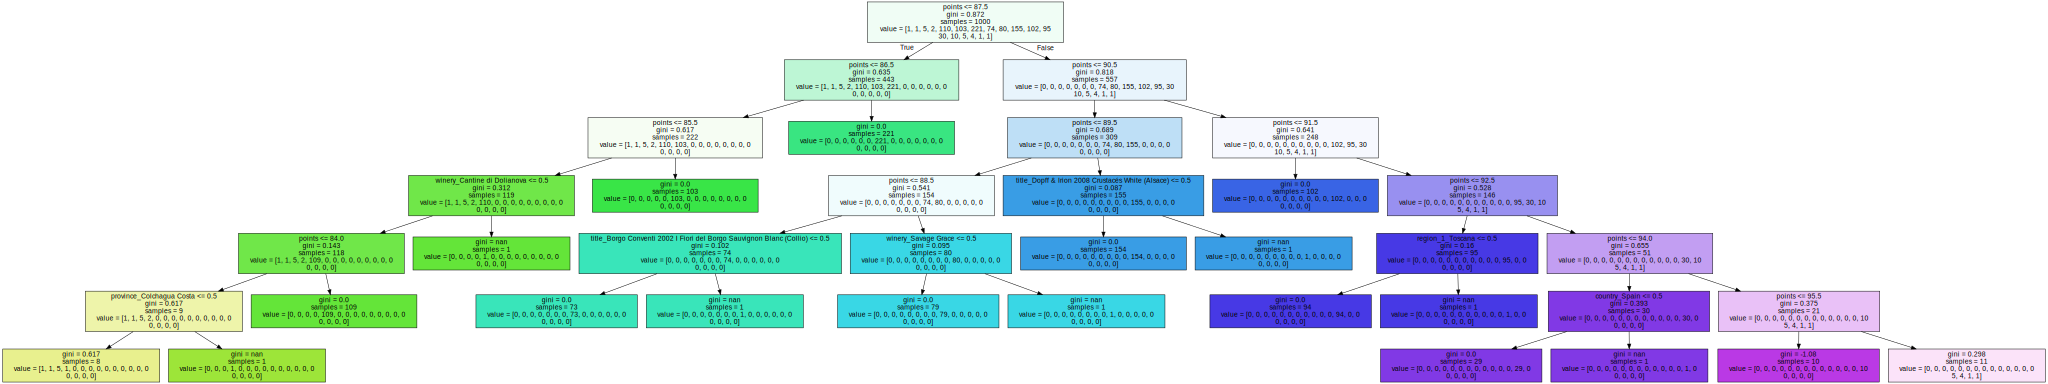

In [13]:
modelo = DecisionTreeClassifier()
modelo.fit(X=explicativas, y=objetivo)

#plot_tree(decision_tree=modelo, feature_names=explicativas.columns, filled=True)

clf = tree.DecisionTreeClassifier(criterion='gini', max_depth=6)
clf = clf.fit(explicativas, objetivo)

dot_data = tree.export_graphviz(clf, out_file=None, feature_names=explicativas.columns, filled=True)
graph = graphviz.Source(dot_data)
graph